In [94]:
%matplotlib inline

import gym
import matplotlib
import numpy as np
import sys

from collections import defaultdict

if "../" not in sys.path:
  sys.path.append("../") 
from lib.envs.blackjack import BlackjackEnv, sum_hand
from lib import plotting

matplotlib.style.use('ggplot')

In [95]:
env = BlackjackEnv()
env.seed(123)

[123]

In [96]:
def mc_prediction(policy, env, num_episodes, discount_factor=1.0, print_details=True):
    """
    Monte Carlo prediction algorithm. Calculates the value function
    for a given policy using sampling.
    
    Args:
        policy: A function that maps an observation to action probabilities.
        env: OpenAI gym environment.
        num_episodes: Number of episodes to sample.
        discount_factor: Gamma discount factor.
    
    Returns:
        A dictionary that maps from state -> value.
        The state is a tuple and the value is a float.
    """

    # Keeps track of sum and count of returns for each state
    # to calculate an average. We could use an array to save all
    # returns (like in the book) but that's memory inefficient.
    returns_sum = defaultdict(float)
    returns_count = defaultdict(float)
    
    # The final value function
    V = defaultdict(float)
    
    # Implement this!
    for e in range(1, num_episodes+1):
        # Print out which episode we're on, useful for debugging.
        if e % 1000 == 0:
            print("\rEpisode {}/{}.".format(e, num_episodes), end="")
            sys.stdout.flush()
            
        episode = []
        state = env.reset()
        for t in range(100):
            if print_details:
                print_observation(state)
            action = sample_policy(state)
            if print_details:
                print("Taking action: {}".format( ["Stick", "Hit"][action]))
            
            next_state, reward, done, _ = env.step(action)
            
            # An episode is an array of (state, action, reward) tuple
            episode.append((state, action, reward))
            if done:
                if print_details:
                    print_observation(state)
                    print("Game end. Dealer score: {}, Reward: {}\n".format(sum_hand(env.dealer), float(reward)))
                break
            
            state = next_state

        # Find all the states in this episode 
        states_in_episodes = [x[0] for x in episode]
        
        # MC policy evaluation (In this task, the same state never recurs within one episode, 
        # so there is no difference between first-visit and every-visit MC methods.)
        for state_index, s in enumerate(states_in_episodes):
            # Calculate return in this episode for state s 
            G = sum([x[2]*(discount_factor**i) for i, x in enumerate(episode[state_index:])])
            
            # Increment total return
            returns_sum[s] += G
            
            # Add 1 episode
            returns_count[s] += 1.0
            
            # Value is estimated by mean return
            V[s] = returns_sum[s] / returns_count[s]
        
    return V    

In [97]:
def sample_policy(observation):
    """
    A policy that sticks if the player score is > 20 and hits otherwise.
    """
    score, dealer_score, usable_ace = observation
    return 0 if score >= 20 else 1

In [98]:
def print_observation(observation):
    score, dealer_score, usable_ace = observation
    print("Player Score: {} (Usable Ace: {}), Dealer Score: {}".format(
          score, usable_ace, dealer_score))

In [101]:
v_20 = mc_prediction(sample_policy, env, num_episodes=20, print_details=True)

Player Score: 15 (Usable Ace: False), Dealer Score: 3
Taking action: Hit
Player Score: 15 (Usable Ace: False), Dealer Score: 3
Game end. Dealer score: 11, Reward: -1.0

Player Score: 16 (Usable Ace: False), Dealer Score: 10
Taking action: Hit
Player Score: 16 (Usable Ace: False), Dealer Score: 10
Game end. Dealer score: 13, Reward: -1.0

Player Score: 13 (Usable Ace: False), Dealer Score: 10
Taking action: Hit
Player Score: 19 (Usable Ace: False), Dealer Score: 10
Taking action: Hit
Player Score: 19 (Usable Ace: False), Dealer Score: 10
Game end. Dealer score: 14, Reward: -1.0

Player Score: 13 (Usable Ace: False), Dealer Score: 1
Taking action: Hit
Player Score: 13 (Usable Ace: False), Dealer Score: 1
Game end. Dealer score: 12, Reward: -1.0

Player Score: 12 (Usable Ace: False), Dealer Score: 10
Taking action: Hit
Player Score: 13 (Usable Ace: False), Dealer Score: 10
Taking action: Hit
Player Score: 13 (Usable Ace: False), Dealer Score: 10
Game end. Dealer score: 15, Reward: -1.0

P

Episode 10000/10000.

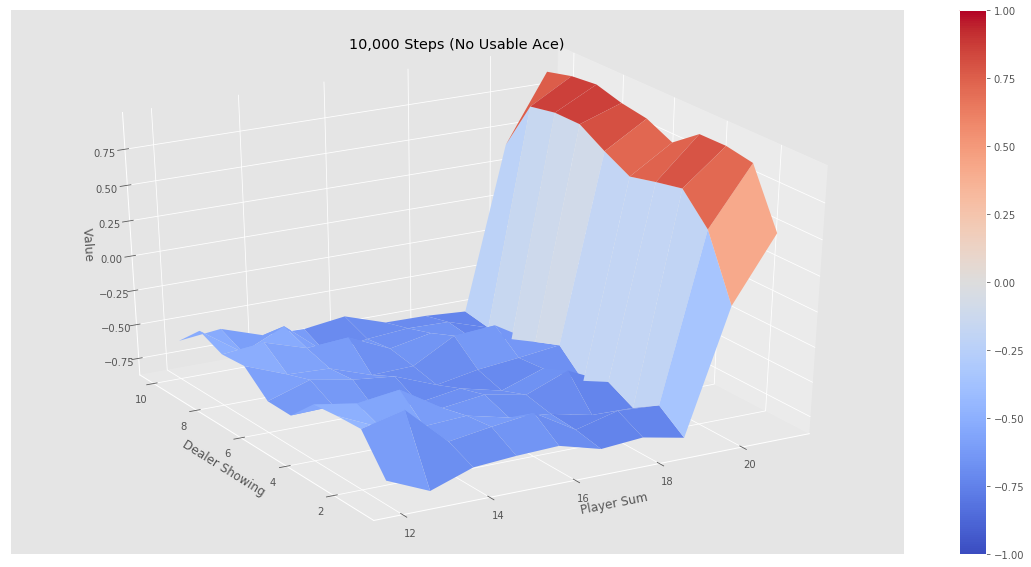

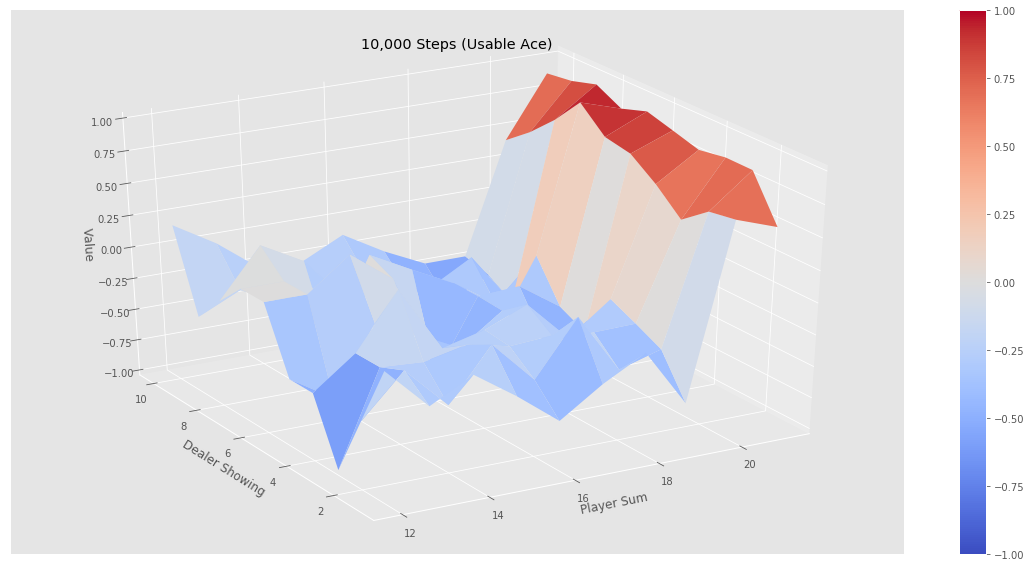

Episode 500000/500000.

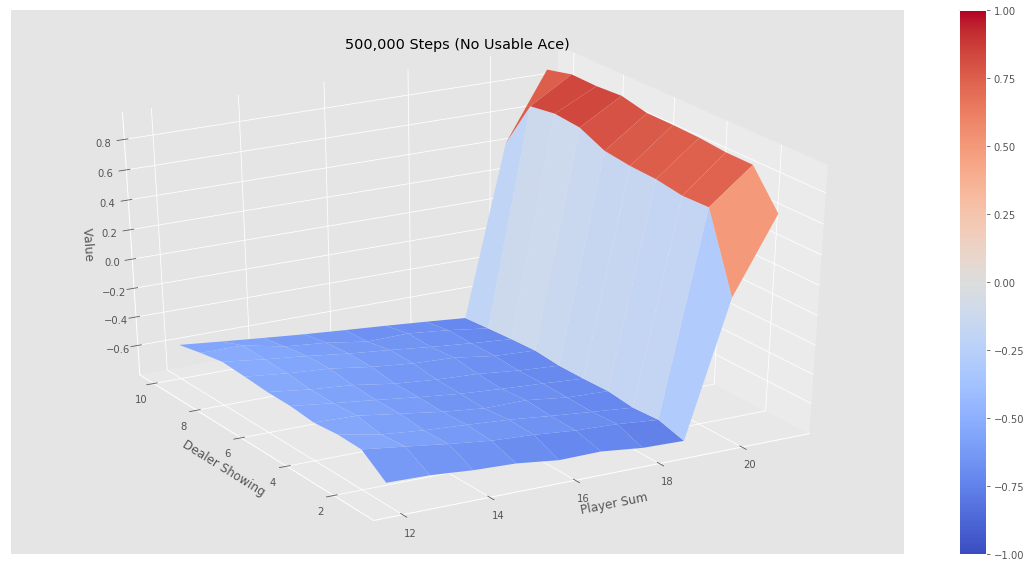

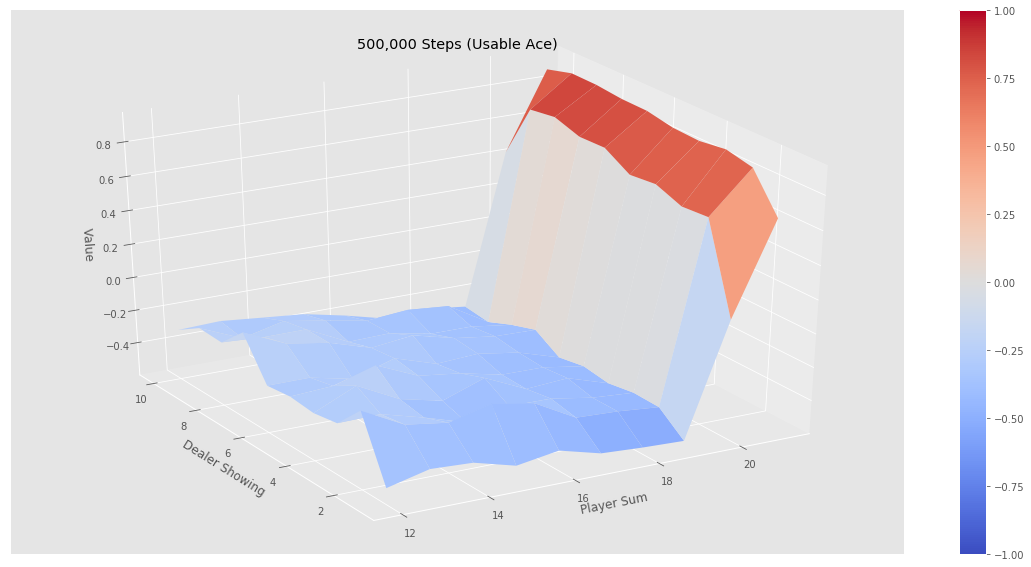

In [100]:
V_10k = mc_prediction(sample_policy, env, num_episodes=10000, print_details=False)
plotting.plot_value_function(V_10k, title="10,000 Steps")

V_500k = mc_prediction(sample_policy, env, num_episodes=500000, print_details=False)
plotting.plot_value_function(V_500k, title="500,000 Steps")

From the 500,000 episodes MC prediction, we observed:
1. State-value function jumps when player sum is 20 and reach the highest when player sum is 21. 
2. The state-value function is higher if the player has usable Ace, although the player sum is the same. 
3. When player sum is 19, the sate-value function is the lowest because it would be easy to exceed 21 after hitting another card. 
4. When the dealer showing card is 1 or 10, the state-value function dropped. 